In [11]:
# Section 1: Import Libraries and Helpers
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add the project root to the system path
if project_root not in sys.path:
    sys.path.append(project_root)


import joblib
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from helpers.visualization_helpers import plot_confusion_matrix, display_classification_report
from tensorflow.keras.models import load_model

In [ ]:
# Section 2: Load Preprocessed Data
# Load vectorizers
bow_vectorizer = joblib.load('../outputs/models/bow_vectorizer.joblib')
tfidf_vectorizer = joblib.load('../outputs/models/tfidf_vectorizer.joblib')
spacy_model = joblib.load('../outputs/models/spacy_model.joblib')

# Load training data
X_train_tfidf = joblib.load('../outputs/models/X_train_tfidf_balanced.joblib')
X_train_bow = joblib.load('../outputs/models/X_train_bow_balanced.joblib')
X_train_spacy = joblib.load('../outputs/models/X_train_spacy_balanced.joblib')

y_train_tfidf = joblib.load('../outputs/models/y_train_tfidf_balanced.joblib')
y_train_bow = joblib.load('../outputs/models/y_train_bow_balanced.joblib')
y_train_spacy = joblib.load('../outputs/models/y_train_spacy_balanced.joblib')

# Load test data
X_test_tfidf = joblib.load('../outputs/models/X_test_tfidf.joblib')
y_test = joblib.load('../outputs/models/y_test.joblib')

print("Preprocessed data loaded successfully.")

In [ ]:
# Section 3: Prepare Data for Neural Network
# Convert sparse matrices to dense
X_train_dense = X_train_tfidf.toarray()  # Change this to the desired vectorization
X_test_dense = X_test_tfidf.toarray()    # Change this to the desired vectorization

# One-hot encode the target labels
y_train_categorical = to_categorical(y_train_tfidf - 1, num_classes=5)  # Adjust labels to start from 0
y_test_categorical = to_categorical(y_test - 1, num_classes=5)

In [47]:
# Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import joblib
import spacy

# Step 1: Load Preprocessed Data
# Load your dataset here
# Assuming X_train, X_test, y_train, y_test are available

# Load SpaCy model
nlp = spacy.load("en_core_web_lg")

# Step 2: Vectorize Text Using Different Techniques

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# BoW Vectorization
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# SpaCy Embeddings
def spacy_vectorizer(texts, nlp_model):
    vectors = []
    for doc in nlp_model.pipe(texts, disable=["parser", "ner"]):
        vectors.append(doc.vector)
    return np.array(vectors)

X_train_spacy = spacy_vectorizer(X_train, nlp)
X_test_spacy = spacy_vectorizer(X_test, nlp)

# Save Vectorizers and Transformed Data
joblib.dump(tfidf_vectorizer, "../outputs/models/tfidf_vectorizer.joblib")
joblib.dump(bow_vectorizer, "../outputs/models/bow_vectorizer.joblib")

# Step 3: Train Models with Each Embedding

# Define the neural network architecture
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_shape=(input_dim,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(5, activation='softmax'))  # 5 classes for ratings 1-5
    return model

# Define model configurations
embedding_methods = {
    "TF-IDF": (X_train_tfidf, X_test_tfidf),
    "BoW": (X_train_bow, X_test_bow),
    "SpaCy": (X_train_spacy, X_test_spacy)
}

results = {}
trained_models = {}

for method, (X_train_emb, X_test_emb) in embedding_methods.items():
    # Create model
    input_dim = X_train_emb.shape[1] if method != "SpaCy" else X_train_emb.shape[-1]
    model = create_model(input_dim)

    # Compile the model
    optimizer = RMSprop(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Compute class weights
    y_train = np.argmax(y_train_categorical, axis=1)
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)

    # Train the model
    print(f"\nTraining with {method} Embedding...")
    history = model.fit(
        X_train_emb,
        y_train_categorical,
        validation_split=0.1,
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights,
        verbose=1
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test_emb, y_test_categorical, verbose=1)
    print(f"\nTest Accuracy with {method} Embedding: {test_accuracy:.4f}")

    # Save results and model
    results[method] = {
        "accuracy": test_accuracy,
        "history": history
    }
    model_save_path = f"../outputs/models/Neural_Network_{method}.keras"
    model.save(model_save_path)
    print(f"\nNeural Network model with {method} saved successfully.")
    trained_models[method] = model

# Step 4: Compare Results
print("\nModel Performance Comparison:")
for method, result in results.items():
    print(f"{method} Embedding - Test Accuracy: {result['accuracy']:.4f}")

NameError: name 'X_train' is not defined

In [8]:
# Save the model in native Keras format
model_save_path = '../outputs/models/neural_network_model.keras'
model.save(model_save_path)
print(f"Neural Network model saved successfully to {model_save_path}.")

Neural Network model saved successfully to ../outputs/models/neural_network_model.keras.



Test Accuracy: 0.5804
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           1       0.62      0.62      0.62       284
           2       0.44      0.38      0.41       359
           3       0.38      0.27      0.32       437
           4       0.46      0.52      0.49      1208
           5       0.72      0.73      0.72      1811

    accuracy                           0.58      4099
   macro avg       0.52      0.50      0.51      4099
weighted avg       0.58      0.58      0.58      4099

Figure saved to ../outputs/figures/neural_network_confusion_matrix.png


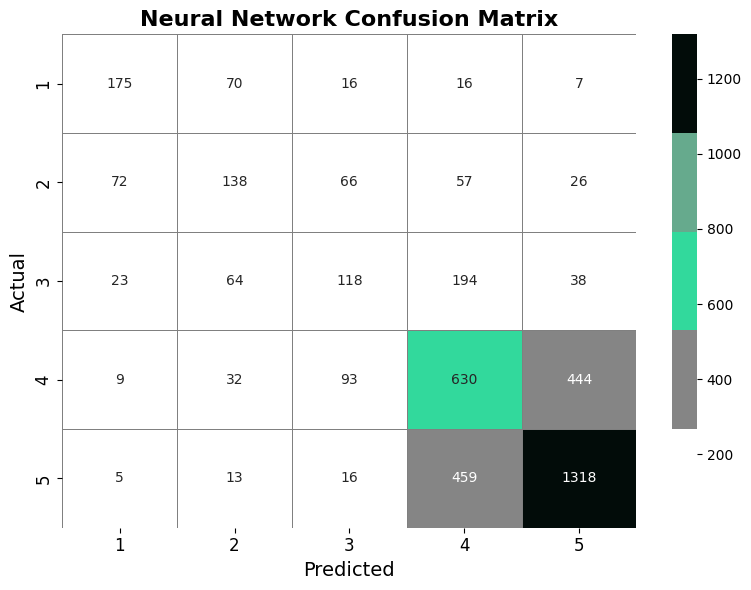


Neural Network model saved successfully.


In [12]:
# Section 6: Model Evaluation

# Evaluate on test data
loss, accuracy = model.evaluate(X_test_dense, y_test_categorical, verbose=0)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_probs = model.predict(X_test_dense)
y_pred = np.argmax(y_pred_probs, axis=1) + 1  # Adjust labels back to 1-5

# Display Classification Report
display_classification_report(y_test, y_pred)

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred, 
                             classes=[1, 2, 3, 4, 5], 
                             title="Neural Network Confusion Matrix", 
                             save_path='../outputs/figures/neural_network_confusion_matrix.png')

# Section 7: Save the Trained Model

# Save the entire model
model = load_model('../outputs/models/Neural_Network_TFIDF.keras')
print("\nNeural Network model saved successfully.")


In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input


# Number of classes (assuming ratings from 1 to 5)
num_classes = 5

# Function to prepare data for NN
def prepare_nn_data(X, y):
    y_cat = to_categorical(y - 1, num_classes)  # Adjust labels to start from 0
    if hasattr(X, 'toarray'):
        X = X.toarray()  # Convert sparse matrix to dense if necessary
    return X, y_cat

# Neural Network with TFIDF
X_nn_tfidf, y_nn_tfidf = prepare_nn_data(X_train_tfidf, y_train_tfidf)

nn_tfidf = Sequential([
    Input(shape=(X_nn_tfidf.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])


nn_tfidf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn_tfidf.fit(X_nn_tfidf, y_nn_tfidf, epochs=5, batch_size=32)
nn_tfidf.save('../outputs/models/Neural_Network_TFIDF.keras')

# Neural Network with BOW
X_nn_bow, y_nn_bow = prepare_nn_data(X_train_bow, y_train_bow)

nn_bow = Sequential([
    Input(shape=(X_nn_bow.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

nn_bow.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn_bow.fit(X_nn_bow, y_nn_bow, epochs=5, batch_size=32)
nn_bow.save('../outputs/models/Neural_Network_BOW.keras')

# Neural Network with spaCy
X_nn_spacy, y_nn_spacy = prepare_nn_data(X_train_spacy, y_train_spacy)

nn_spacy = Sequential([
    Input(shape=(X_nn_spacy.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

nn_spacy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
nn_spacy.fit(X_nn_spacy, y_nn_spacy, epochs=5, batch_size=32)
nn_spacy.save('../outputs/models/Neural_Network_SPACY.keras')



Epoch 1/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6415 - loss: 0.8800
Epoch 2/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8973 - loss: 0.2678
Epoch 3/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9366 - loss: 0.1649
Epoch 4/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9674 - loss: 0.0945
Epoch 5/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9901 - loss: 0.0385
Epoch 1/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5673 - loss: 1.0435
Epoch 2/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8007 - loss: 0.4977
Epoch 3/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9025 - loss: 0.2715
Epoch 4/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9499 - loss: 0.1470
Epoch 5/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9697 - loss: 0.0937
Epoch 1/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4824 - loss: 1.1683
Epoch 2/5
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 1s